In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [47]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [48]:
dtype_dict = {
    "Index": "int64",
    "Order ID": "string",
    "Ship Mode": "category",
    "Customer ID": "string",
    "Customer Name": "string",
    "Origin Channel": "category",
    "Country/Region": "category",
    "City": "string",
    "State": "category",
    "Postal Code": "string",  
    "Region": "category",
    "Category": "category",
    "Sub-Category": "category",
    "Product ID": "string",
    "Sales": "float64",
    "Quantity": "int64",
    "Discount": "float64",
    "Profit": "float64"
}

orders = pd.read_excel(
    "./Muesli Project raw data.xlsx",
    sheet_name="Orders",
    header=1,
    dtype=dtype_dict,
    parse_dates=["Order Date"]   
)

In [49]:
orders = orders.drop(columns=["Category", "Sub-Category", "Product ID", "Sales", "Quantity", "Discount", "Profit"])

In [50]:
campaign_dtypes = {
    "Order ID": "string",
    "Customer Name": "string"
}
campaign = pd.read_excel(
    "./Muesli Project raw data.xlsx",
    sheet_name="Campaign Data",
    dtype=campaign_dtypes,
    parse_dates=["Arrival Scan Date"]
)

In [51]:
order_dtypes = {
    "Row ID": "int64",
    "Order ID": "string",
    "Ship Mode": "category"
}
order = pd.read_excel(
    "./Muesli Project raw data.xlsx",
    sheet_name="Order Process Data",
    dtype=order_dtypes,
    parse_dates=["Order Date", "On Truck Scan Date"]
)


In [52]:
intern_dtypes = {
    "Order ID": "string"
}
intern = pd.read_excel(
    "./Muesli Project raw data.xlsx",
    sheet_name="InternData Study",
    dtype=intern_dtypes,
    parse_dates=["Ready to Ship Date", "Pickup Date"]
)


In [53]:
muesli_all = orders.merge(campaign, on="Order ID", how="left") \
               .merge(order, on="Order ID", how="left") \
               .merge(intern, on="Order ID", how="left")

In [54]:
muesli_all.columns = muesli_all.columns.str.lower()

In [55]:
muesli_all = muesli_all.drop(columns=["customer name_y", "order date_y"])

In [56]:
muesli_all = muesli_all.rename(columns={'order date_x': 'order date',
                                        "ship mode_x": "ship mode",
                                        "customer name_x": "customer name"})

In [57]:
muesli_all['order_date_day'] = muesli_all['order date'].dt.day_name()
muesli_all['arrival_scan_day'] = muesli_all['arrival scan date'].dt.day_name()
muesli_all['on_truck_scan_day'] = muesli_all['on truck scan date'].dt.day_name()
muesli_all['ready_to_ship_day'] = muesli_all['ready to ship date'].dt.day_name()
muesli_all['pickup_day'] = muesli_all['pickup date'].dt.day_name()

In [58]:
muesli_all = muesli_all.drop(columns=["index", "row id", "country/region"])

In [59]:
muesli_all = muesli_all.drop_duplicates()

In [60]:
muesli_all.shape

(5010, 20)

In [169]:
muesli_all.dtypes

order id                     string[python]
order date                   datetime64[ns]
ship mode                          category
customer id                  string[python]
customer name                string[python]
origin channel                     category
city                         string[python]
state                              category
postal code                  string[python]
region                             category
arrival scan date            datetime64[ns]
on truck scan date           datetime64[ns]
ship mode_y                        category
ready to ship date           datetime64[ns]
pickup date                  datetime64[ns]
order_date_day                       object
arrival_scan_day                     object
on_truck_scan_day                    object
ready_to_ship_day                    object
pickup_day                           object
time_order_ship             timedelta64[ns]
time_order_ship_adjusted    timedelta64[ns]
order_year                      

In [62]:
muesli_all['time_order_ship'] = muesli_all['ready to ship date'] - muesli_all['order date']


In [63]:
muesli_step1 = muesli_all[muesli_all['time_order_ship'].notna()]

In [111]:
muesli_step1.shape

(204, 21)

In [64]:
mean_days = muesli_step1['time_order_ship'].dt.days.mean()
min_days = muesli_step1['time_order_ship'].dt.days.min()
max_days = muesli_step1['time_order_ship'].dt.days.max()

print(f"Mittelwert: {mean_days:.2f} Tage")
print(f"Range: {min_days} - {max_days} Tage")

Mittelwert: 4.18 Tage
Range: 0 - 8 Tage


In [106]:
ship_mode_stats = muesli_step1.groupby('ship mode')['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean(),
    min_days=lambda x: x.dt.days.min(),
    max_days=lambda x: x.dt.days.max()
).reset_index()

print(ship_mode_stats)

        ship mode  mean_days  min_days  max_days
0     First Class   2.037736         0         5
1    Second Class   3.863636         2         7
2  Standard Class   5.364486         2         8


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/4139772634.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ship_mode_stats = muesli_step1.groupby('ship mode')['time_order_ship'].agg(


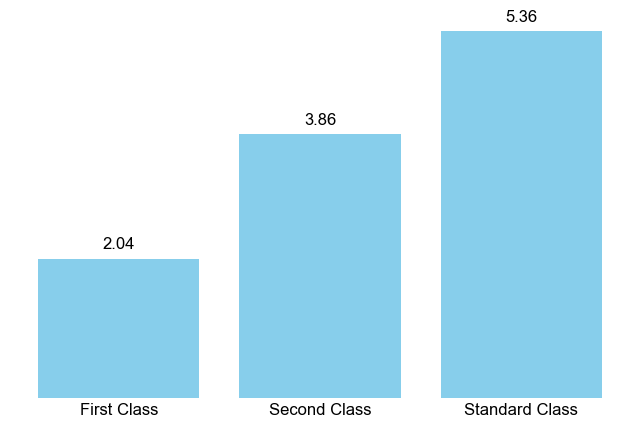

In [76]:
import matplotlib.pyplot as plt

x = ship_mode_stats['ship mode']
y = ship_mode_stats['mean_days']

plt.figure(figsize=(8,5))
bars = plt.bar(x, y, color='skyblue')

for bar, value in zip(bars, y):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.1, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=12, fontname='Arial')


plt.xticks(fontsize=12, fontname='Arial') 
plt.yticks([])  

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tick_params(axis='x', length=0)

plt.show()

In [66]:
origin_channel_stats = muesli_step1.groupby('origin channel')['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean(),
    min_days=lambda x: x.dt.days.min(),
    max_days=lambda x: x.dt.days.max()
).reset_index()

print(origin_channel_stats)

  origin channel  mean_days  min_days  max_days
0          Email   4.415094         0         8
1       Facebook   4.054054         0         7
2          Sales   3.836066         0         8


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/1520894849.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  origin_channel_stats = muesli_step1.groupby('origin channel')['time_order_ship'].agg(


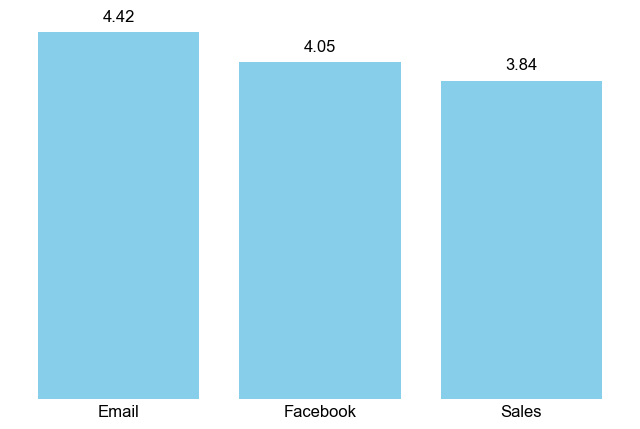

In [80]:
import matplotlib.pyplot as plt

x = origin_channel_stats['origin channel']
y = origin_channel_stats['mean_days']

plt.figure(figsize=(8,5))
bars = plt.bar(x, y, color='skyblue')

for bar, value in zip(bars, y):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.1, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=12, fontname='Arial')


plt.xticks(fontsize=12, fontname='Arial') 
plt.yticks([])  

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tick_params(axis='x', length=0)

plt.show()

In [68]:
ship_type_stats = muesli_step1.groupby('ship mode_y')['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean(),
    min_days=lambda x: x.dt.days.min(),
    max_days=lambda x: x.dt.days.max()
).reset_index()

print(ship_type_stats)

           ship mode_y  mean_days  min_days  max_days
0              Express   2.037736         0         5
1  Standard Processing   4.927152         2         8


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/2944780734.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ship_type_stats = muesli_step1.groupby('ship mode_y')['time_order_ship'].agg(


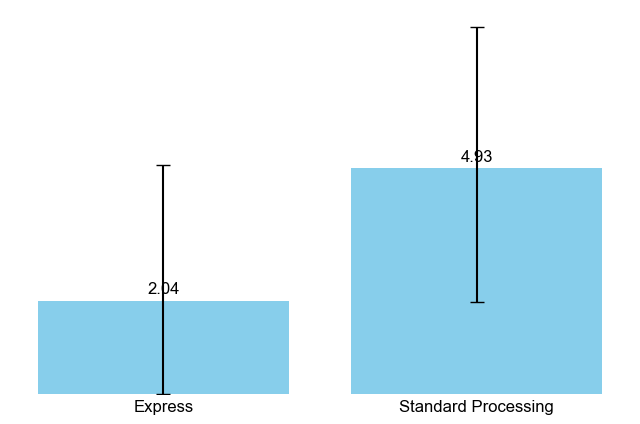

In [ ]:
import matplotlib.pyplot as plt

x = ship_type_stats['ship mode_y']
y = ship_type_stats['mean_days']

yerr = [y - ship_type_stats['min_days'], ship_type_stats['max_days'] - y]

plt.figure(figsize=(8,5))
bars = plt.bar(x, y, color='skyblue', yerr=yerr, capsize=5) 

for bar, value in zip(bars, y):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.1, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=12, fontname='Arial')

plt.xticks(fontsize=12, fontname='Arial') 
plt.yticks([])  

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tick_params(axis='x', length=0)

plt.show()


In [82]:
region_stats = muesli_step1.groupby('region')['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean(),
    min_days=lambda x: x.dt.days.min(),
    max_days=lambda x: x.dt.days.max()
).reset_index()

print(region_stats)

    region  mean_days  min_days  max_days
0  Central   4.274510         0         7
1     East   4.269231         0         8
2    South   4.414634         0         8
3     West   3.850000         0         7


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/2397413866.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_stats = muesli_step1.groupby('region')['time_order_ship'].agg(


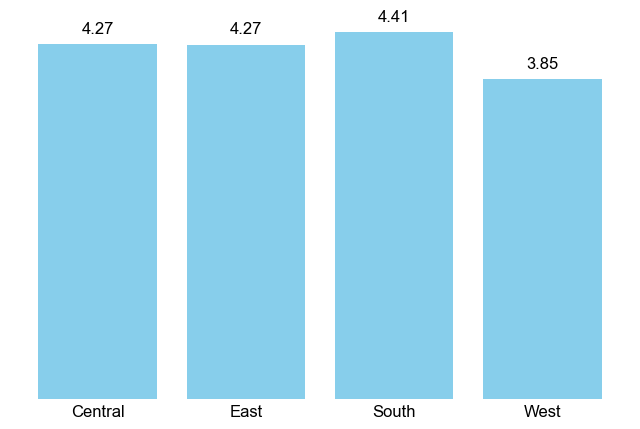

In [81]:
import matplotlib.pyplot as plt

x = region_stats['region']
y = region_stats['mean_days']

plt.figure(figsize=(8,5))
bars = plt.bar(x, y, color='skyblue')

for bar, value in zip(bars, y):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.1, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=12, fontname='Arial')


plt.xticks(fontsize=12, fontname='Arial') 
plt.yticks([])  

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tick_params(axis='x', length=0)

plt.show()

/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/3609695992.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_ship_stats = muesli_step1.groupby(['region', 'ship mode_y'])['time_order_ship'].agg(


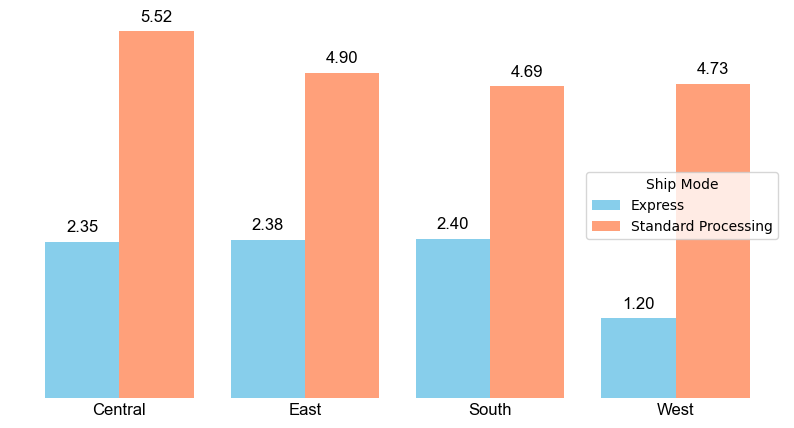

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

region_ship_stats = muesli_step1.groupby(['region', 'ship mode_y'])['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean()
    ).reset_index()

regions = region_ship_stats['region'].unique()
ship_modes = region_ship_stats['ship mode_y'].unique()

x = np.arange(len(regions))
width = 0.4 

plt.figure(figsize=(10,5))

colors = ['skyblue', 'lightsalmon']

for i, ship in enumerate(ship_modes):
    y = [region_ship_stats.loc[(region_ship_stats['region']==r) & 
                               (region_ship_stats['ship mode_y']==ship), 'mean_days'].values[0]
         for r in regions]
    
    plt.bar(x + i*width, y, width=width, label=ship, color=colors[i])
    
    for xi, yi in zip(x + i*width, y):
        plt.text(xi, yi + 0.1, f'{yi:.2f}', ha='center', va='bottom', fontsize=12, fontname='Arial')

plt.xticks(x + width*(len(ship_modes)-1)/2, regions, fontsize=12, fontname='Arial', rotation=0, ha='center')
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(axis='x', length=0)

plt.legend(title='Ship Mode')
plt.show()


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/1923588422.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  origin_channel_stats = muesli_step1.groupby(['origin channel', 'ship mode_y'])['time_order_ship'].agg(


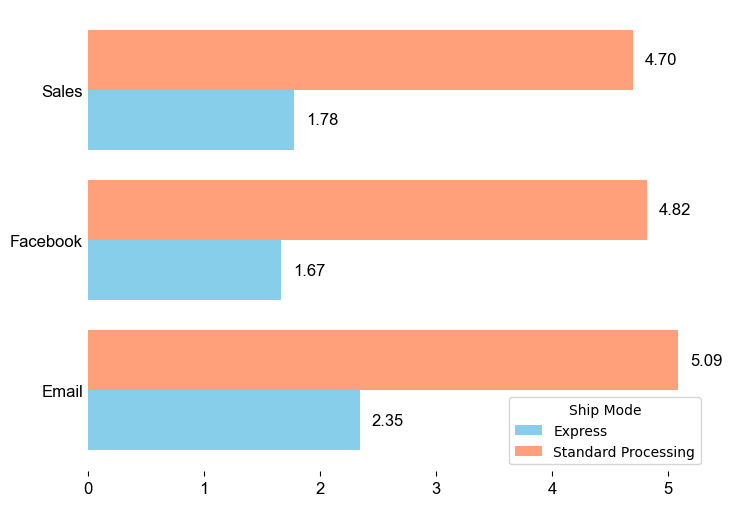

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

origin_channel_stats = muesli_step1.groupby(['origin channel', 'ship mode_y'])['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean()
).reset_index()

regions = origin_channel_stats['origin channel'].unique()
ship_modes = origin_channel_stats['ship mode_y'].unique()

y = np.arange(len(regions))  
height = 0.4  

plt.figure(figsize=(8,6))
colors = ['skyblue', 'lightsalmon']

for i, ship in enumerate(ship_modes):
    xvals = [
        origin_channel_stats.loc[
            (origin_channel_stats['origin channel']==r) & 
            (origin_channel_stats['ship mode_y']==ship), 'mean_days'
        ].values[0] for r in regions
    ]
    
    plt.barh(y + i*height, xvals, height=height, label=ship, color=colors[i])
    
    for yi, xi in zip(y + i*height, xvals):
        plt.text(xi + 0.1, yi, f'{xi:.2f}', va='center', ha='left', fontsize=12, fontname='Arial')

# Achsen minimalistisch
plt.yticks(y + height*(len(ship_modes)-1)/2, regions, fontsize=12, fontname='Arial')
plt.xticks(fontsize=12, fontname='Arial')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(axis='y', length=0)

plt.legend(title='Ship Mode')

plt.show()


In [99]:
muesli_all['time_order_ship_adjusted'] = muesli_all['time_order_ship']

muesli_all.loc[muesli_all['order_date_day'] == 'Saturday', 'time_order_ship_adjusted'] = \
    muesli_all['time_order_ship'] - pd.Timedelta(days=2)

muesli_all.loc[muesli_all['order_date_day'] == 'Sunday', 'time_order_ship_adjusted'] = \
    muesli_all['time_order_ship'] - pd.Timedelta(days=1)

/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/3609695992.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_ship_stats = muesli_step1.groupby(['region', 'ship mode_y'])['time_order_ship'].agg(


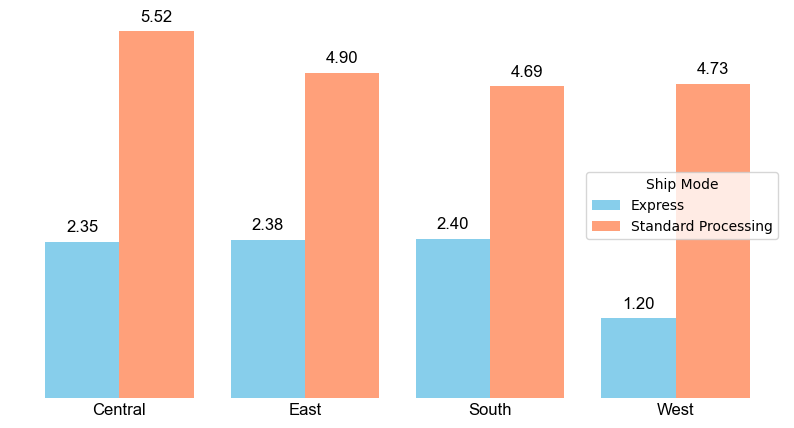

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

region_ship_stats = muesli_step1.groupby(['region', 'ship mode_y'])['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean()
    ).reset_index()

regions = region_ship_stats['region'].unique()
ship_modes = region_ship_stats['ship mode_y'].unique()

x = np.arange(len(regions))
width = 0.4 

plt.figure(figsize=(10,5))

colors = ['skyblue', 'lightsalmon']

for i, ship in enumerate(ship_modes):
    y = [region_ship_stats.loc[(region_ship_stats['region']==r) & 
                               (region_ship_stats['ship mode_y']==ship), 'mean_days'].values[0]
         for r in regions]
    
    plt.bar(x + i*width, y, width=width, label=ship, color=colors[i])
    
    for xi, yi in zip(x + i*width, y):
        plt.text(xi, yi + 0.1, f'{yi:.2f}', ha='center', va='bottom', fontsize=12, fontname='Arial')

# Achsen minimalistisch
plt.xticks(x + width*(len(ship_modes)-1)/2, regions, fontsize=12, fontname='Arial', rotation=0, ha='center')
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(axis='x', length=0)

plt.legend(title='Ship Mode')
plt.show()


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/939977429.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_ship_stats = muesli_step1.groupby(['order_date_day', 'ship mode_y'])['time_order_ship'].agg(


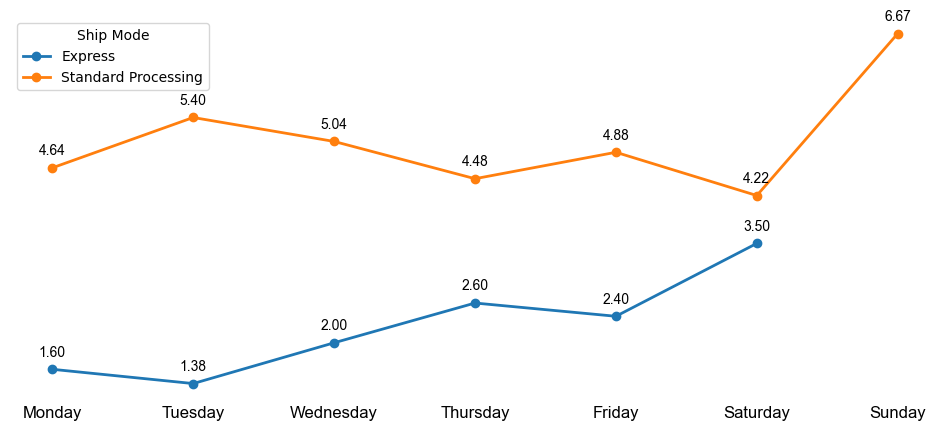

In [147]:
import matplotlib.pyplot as plt
import numpy as np

weekday_ship_stats = muesli_step1.groupby(['order_date_day', 'ship mode_y'])['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean()
).reset_index()

weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'] 
ship_modes = weekday_ship_stats['ship mode_y'].unique()

x = np.arange(len(weekdays))
width = 0.4 

plt.figure(figsize=(12,5))

colors = ['skyblue', 'lightsalmon'] 

for i, ship in enumerate(ship_modes):
    # Fehlende Kombinationen als NaN statt 0
    y = [
        weekday_ship_stats.loc[
            (weekday_ship_stats['order_date_day'] == d) &
            (weekday_ship_stats['ship mode_y'] == ship), 'mean_days'
        ].values[0] if not weekday_ship_stats.loc[
            (weekday_ship_stats['order_date_day'] == d) &
            (weekday_ship_stats['ship mode_y'] == ship), 'mean_days'
        ].empty else np.nan
        for d in weekdays
    ]

    plt.plot(x, y, marker="o", label=ship, linewidth=2)

    # IMMER beschriften (0 inkl.), nur NaN überspringen
    for xi, yi in zip(x, y):
        if np.isfinite(yi):
            plt.text(
                xi, yi + 0.15,       # 0.15 über dem Punkt
                f"{yi:.2f}",
                ha="center", va="bottom",
                fontsize=10, fontname="Arial"
            )

        

plt.xticks(x, weekdays, fontsize=12, fontname='Arial', rotation=0, ha='center')

plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(axis='x', length=0)

plt.legend(title='Ship Mode')
plt.show()


In [104]:
import pandas as pd

muesli_all['time_order_ship_adjusted'] = muesli_all['time_order_ship']

muesli_all.loc[muesli_all['order_date_day'] == 'Saturday', 'time_order_ship_adjusted'] = \
    muesli_all['time_order_ship'] - pd.Timedelta(days=2)

muesli_all.loc[muesli_all['order_date_day'] == 'Sunday', 'time_order_ship_adjusted'] = \
    muesli_all['time_order_ship'] - pd.Timedelta(days=1)

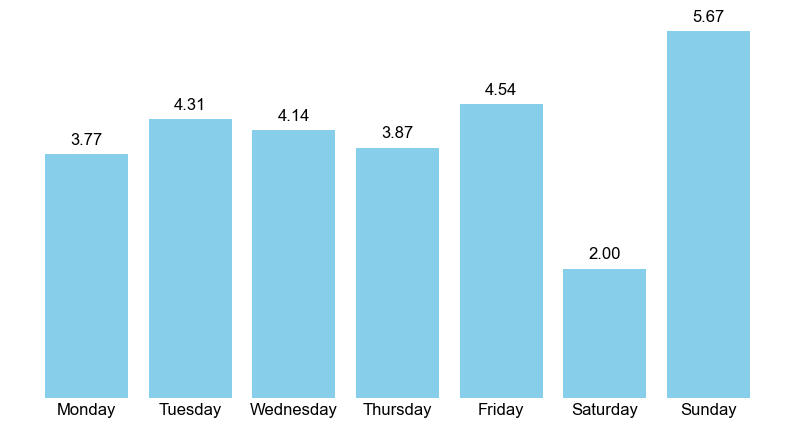

In [113]:
import matplotlib.pyplot as plt

weekday_stats = muesli_all.groupby('order_date_day')['time_order_ship_adjusted'].agg(
    mean_days=lambda x: x.dt.days.mean()
).reset_index()

weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

weekday_stats['order_date_day'] = pd.Categorical(weekday_stats['order_date_day'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('order_date_day')

x = weekday_stats['order_date_day']
y = weekday_stats['mean_days']

plt.figure(figsize=(10,5))
bars = plt.bar(x, y, color='skyblue')

for bar, value in zip(bars, y):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.1, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=12, fontname='Arial')

plt.xticks(fontsize=12, fontname='Arial')
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(axis='x', length=0)

plt.show()



/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/54251320.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_ship_stats = muesli_step1.groupby(['order_date_day', 'origin channel'])['time_order_ship'].agg(


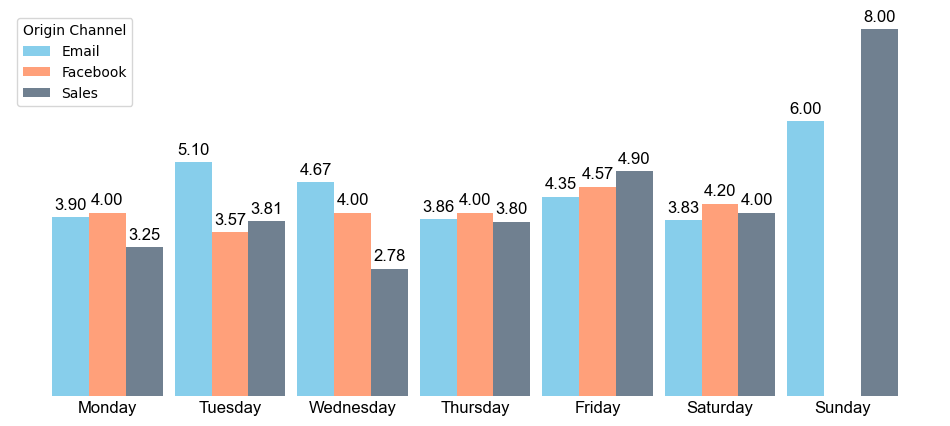

In [118]:
import matplotlib.pyplot as plt
import numpy as np

weekday_ship_stats = muesli_step1.groupby(['order_date_day', 'origin channel'])['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean()
).reset_index()

weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'] 
ship_modes = weekday_ship_stats['origin channel'].unique()

x = np.arange(len(weekdays))
width = 0.3 

plt.figure(figsize=(12,5))

colors = ['skyblue', 'lightsalmon', "slategrey"] 

for i, ship in enumerate(ship_modes):
    y = [weekday_ship_stats.loc[
            (weekday_ship_stats['order_date_day']==d) & 
            (weekday_ship_stats['origin channel']==ship), 'mean_days'
        ].values[0] if not weekday_ship_stats.loc[
            (weekday_ship_stats['order_date_day']==d) & 
            (weekday_ship_stats['origin channel']==ship), 'mean_days'
        ].empty else 0 for d in weekdays]
    
    plt.bar(x + i*width, y, width=width, label=ship, color=colors[i])
    
    for xi, yi in zip(x + i*width, y):
        if yi > 0:
            plt.text(xi, yi + 0.1, f'{yi:.2f}', ha='center', va='bottom', fontsize=12, fontname="Arial")
        

plt.xticks(x + width*(len(ship_modes)-1)/2, weekdays, fontsize=12, fontname='Arial', rotation=0, ha='center')
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(axis='x', length=0)

plt.legend(title='Origin Channel')
plt.show()

In [125]:
muesli_step1['order_year'] = muesli_step1['order date'].dt.year
muesli_step1['order_month'] = muesli_step1['order date'].dt.month


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/198271712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muesli_step1['order_year'] = muesli_step1['order date'].dt.year
/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/198271712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muesli_step1['order_month'] = muesli_step1['order date'].dt.month


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/125153731.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_ship_stats = muesli_step1.groupby(['order_month', 'ship mode_y'])['time_order_ship'].agg(


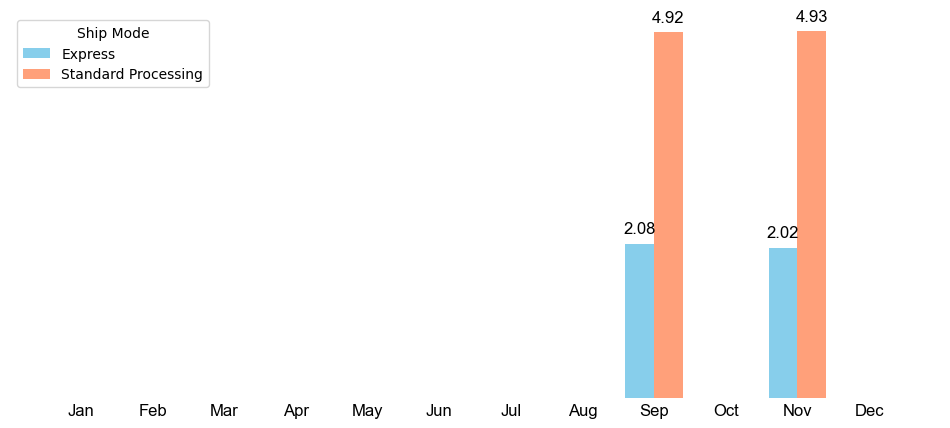

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

month_ship_stats = muesli_step1.groupby(['order_month', 'ship mode_y'])['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean()
).reset_index()

months = list(range(1, 13))
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

ship_modes = month_ship_stats['ship mode_y'].unique()

x = np.arange(len(months))
width = 0.4 

plt.figure(figsize=(12,5))
colors = ['skyblue', 'lightsalmon'] 

for i, ship in enumerate(ship_modes):
    y = [month_ship_stats.loc[
            (month_ship_stats['order_month']==m) & 
            (month_ship_stats['ship mode_y']==ship), 'mean_days'
        ].values[0] if not month_ship_stats.loc[
            (month_ship_stats['order_month']==m) & 
            (month_ship_stats['ship mode_y']==ship), 'mean_days'
        ].empty else 0 for m in months]
    
    plt.bar(x + i*width, y, width=width, label=ship, color=colors[i])
    
    # Zahlen über Balken
    for xi, yi in zip(x + i*width, y):
        if yi > 0:
            plt.text(xi, yi + 0.1, f'{yi:.2f}', 
                     ha='center', va='bottom', fontsize=12, fontname='Arial')

plt.xticks(x + width*(len(ship_modes)-1)/2, month_labels, fontsize=12, fontname='Arial')
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(axis='x', length=0)

plt.legend(title='Ship Mode')
plt.show()



/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/4287053614.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_ship_stats = muesli_step1.groupby(['order_year', 'ship mode_y'])['time_order_ship'].agg(


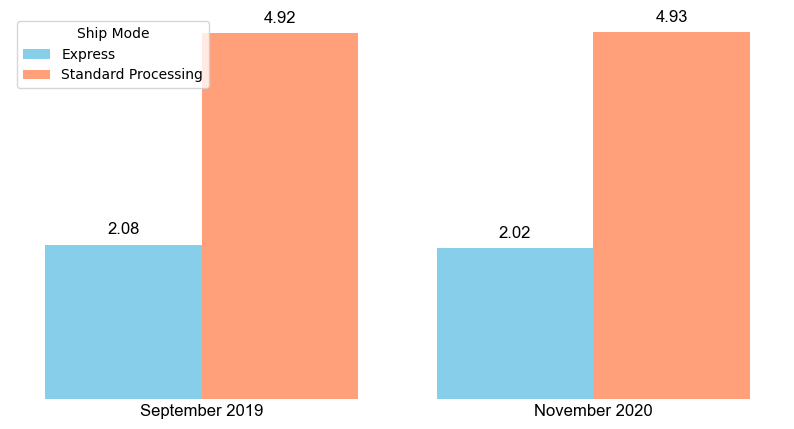

In [131]:
import matplotlib.pyplot as plt
import numpy as np

year_ship_stats = muesli_step1.groupby(['order_year', 'ship mode_y'])['time_order_ship'].agg(
    mean_days=lambda x: x.dt.days.mean()
).reset_index()

years = sorted(year_ship_stats['order_year'].unique())
ship_modes = year_ship_stats['ship mode_y'].unique()

x = np.arange(len(years))
width = 0.4 

plt.figure(figsize=(10,5))
colors = ['skyblue', 'lightsalmon'] 

for i, ship in enumerate(ship_modes):
    y = [year_ship_stats.loc[
            (year_ship_stats['order_year']==yr) & 
            (year_ship_stats['ship mode_y']==ship), 'mean_days'
        ].values[0] if not year_ship_stats.loc[
            (year_ship_stats['order_year']==yr) & 
            (year_ship_stats['ship mode_y']==ship), 'mean_days'
        ].empty else 0 for yr in years]
    
    plt.bar(x + i*width, y, width=width, label=ship, color=colors[i])
    
    # Zahlen über Balken
    for xi, yi in zip(x + i*width, y):
        if yi > 0:
            plt.text(xi, yi + 0.1, f'{yi:.2f}', 
                     ha='center', va='bottom', fontsize=12, fontname='Arial')

custom_labels = ["September 2019", "November 2020"]
plt.xticks(x + width*(len(ship_modes)-1)/2, custom_labels, fontsize=12, fontname='Arial')
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(axis='x', length=0)



plt.legend(title='Ship Mode')
plt.show()


In [156]:
muesli_step1["days"] = muesli_step1["time_order_ship"].dt.days

# --- EXPRESS ---
express = muesli_step1[muesli_step1["ship mode_y"] == "Express"]

express_total = len(express)
express_one_day = (express["days"] <= 1).sum()
express_pct = express_one_day / express_total * 100 if express_total > 0 else 0

print(f"Express Orders insgesamt: {express_total}")
print(f"→ Davon genau 1 Tag: {express_one_day} ({express_pct:.2f}%)")

Express Orders insgesamt: 53
→ Davon genau 1 Tag: 20 (37.74%)


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/427754230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muesli_step1["days"] = muesli_step1["time_order_ship"].dt.days


In [154]:
standard = muesli_step1[muesli_step1["ship mode_y"] == "Standard Processing"]

standard_total = len(standard)
standard_le2_days = (standard["days"] <= 2).sum()  # <= 2 Tage
standard_pct = standard_le2_days / standard_total * 100 if standard_total > 0 else 0

print(f"\nStandard Orders insgesamt: {standard_total}")
print(f"→ Davon ≤ 2 Tage: {standard_le2_days} ({standard_pct:.2f}%)")



Standard Orders insgesamt: 151
→ Davon ≤ 2 Tage: 13 (8.61%)


In [153]:
muesli_step1["ship mode_y"]

20       Standard Processing
38       Standard Processing
95                   Express
169      Standard Processing
220                  Express
                ...         
21862    Standard Processing
21916    Standard Processing
22332    Standard Processing
23045                Express
23070    Standard Processing
Name: ship mode_y, Length: 204, dtype: category
Categories (2, object): ['Express', 'Standard Processing']

In [ ]:
ship_type_range = muesli_step1.groupby('ship mode_y')['time_order_ship'].agg(
    min_days=lambda x: x.dt.days.min(),
    max_days=lambda x: x.dt.days.max(),
    mean_days=lambda x: x.dt.days.mean()
).reset_index()

print(ship_type_range)


           ship mode_y  min_days  max_days  mean_days
0              Express         0         5   2.037736
1  Standard Processing         2         8   4.927152


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/1412512379.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ship_type_range = muesli_step1.groupby('ship mode_y')['time_order_ship'].agg(


In [ ]:
import pandas as pd

weekday_counts = muesli_step1.groupby(['order_date_day', 'ship mode_y']).size().reset_index(name='count')

weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_counts['order_date_day'] = pd.Categorical(
    weekday_counts['order_date_day'], categories=weekdays, ordered=True
)
weekday_counts = weekday_counts.sort_values('order_date_day')

print(weekday_counts)


   order_date_day          ship mode_y  count
2          Monday              Express     10
3          Monday  Standard Processing     25
10        Tuesday              Express     13
11        Tuesday  Standard Processing     35
12      Wednesday              Express     11
13      Wednesday  Standard Processing     26
8        Thursday              Express     10
9        Thursday  Standard Processing     21
0          Friday              Express      5
1          Friday  Standard Processing     32
4        Saturday              Express      4
5        Saturday  Standard Processing      9
6          Sunday              Express      0
7          Sunday  Standard Processing      3


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/560349947.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_counts = muesli_step1.groupby(['order_date_day', 'ship mode_y']).size().reset_index(name='count')


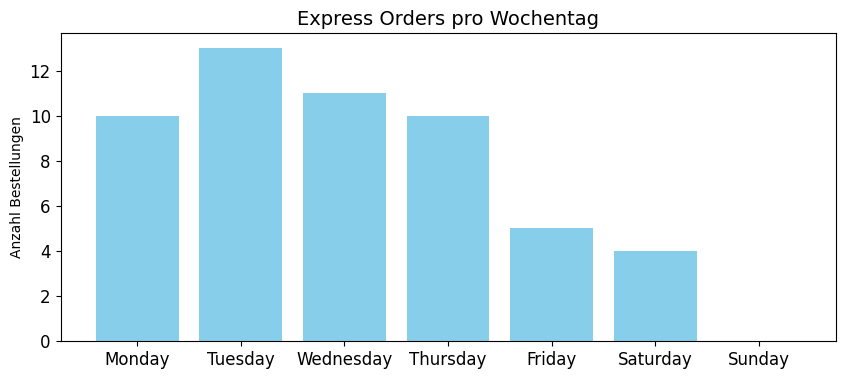

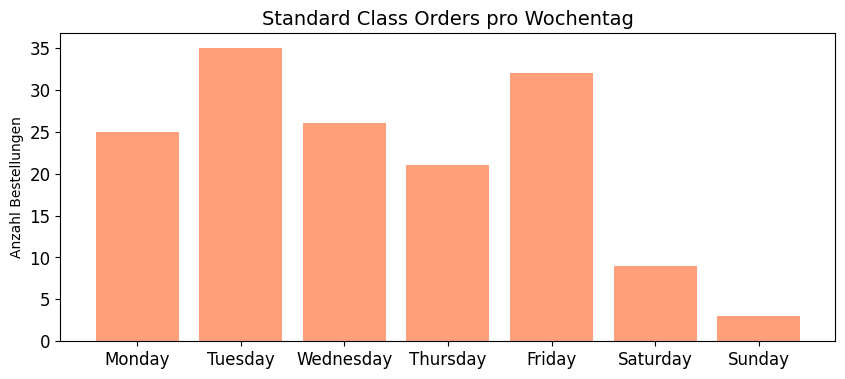

In [ ]:
import matplotlib.pyplot as plt

weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

express_counts = weekday_counts[weekday_counts['ship mode_y'] == 'Express']
express_counts = express_counts.set_index('order_date_day').reindex(weekdays)

plt.figure(figsize=(10,4))
plt.bar(express_counts.index, express_counts['count'], color='skyblue')
plt.title('Express Orders pro Wochentag', fontsize=14)
plt.ylabel('Anzahl Bestellungen')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

standard_counts = weekday_counts[weekday_counts['ship mode_y'] == 'Standard Processing']
standard_counts = standard_counts.set_index('order_date_day').reindex(weekdays)

plt.figure(figsize=(10,4))
plt.bar(standard_counts.index, standard_counts['count'], color='lightsalmon')
plt.title('Standard Class Orders pro Wochentag', fontsize=14)
plt.ylabel('Anzahl Bestellungen')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [166]:
muesli_step1

,order id,order date,ship mode,customer id,customer name,origin channel,city,state,postal code,region,...,pickup date,order_date_day,arrival_scan_day,on_truck_scan_day,ready_to_ship_day,pickup_day,time_order_ship,order_year,order_month,days
20,CA-2020-119004,2020-11-23,Standard Class,JM-15250,Janet Martin,Email,Charlotte,North Carolina,28205,South,...,2020-12-02,Monday,NaN,Wednesday,Monday,Wednesday,7 days,2020,11,7
38,CA-2019-145625,2019-09-11,Standard Class,KC-16540,Kelly Collister,Email,San Diego,California,92037,West,...,2019-09-18,Wednesday,Monday,Wednesday,Tuesday,Wednesday,6 days,2019,9,6
95,CA-2020-135307,2020-11-26,First Class,LS-17245,Lynn Smith,Email,Gladstone,Missouri,64118,Central,...,2020-11-27,Thursday,NaN,Friday,Friday,Friday,1 days,2020,11,1
169,CA-2019-102981,2019-09-06,Second Class,MO-17500,Mary O'Rourke,Email,New York City,New York,10035,East,...,2019-09-11,Friday,Monday,Wednesday,Monday,Wednesday,3 days,2019,9,3
220,US-2020-155425,2020-11-10,First Class,AB-10600,Ann Blume,Sales,Tucson,Arizona,85705,West,...,2020-11-12,Tuesday,NaN,Thursday,Wednesday,Thursday,1 days,2020,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21862,CA-2020-152142,2020-11-14,Standard Class,LW-16990,Lindsay Williams,Sales,San Francisco,California,94110,West,...,2020-11-18,Saturday,NaN,Wednesday,Monday,Wednesday,2 days,2020,11,2
21916,US-2019-134488,2019-09-24,Standard Class,PK-19075,Pete Kriz,Email,Columbus,Ohio,43229,East,...,2019-10-02,Tuesday,NaN,Wednesday,Tuesday,Wednesday,7 days,2019,9,7
22332,CA-2020-103499,2020-11-20,Standard Class,ES-14020,Erica Smith,Email,Jackson,Tennessee,38301,South,...,2020-11-25,Friday,NaN,Wednesday,Tuesday,Wednesday,4 days,2020,11,4
23045,US-2020-165456,2020-11-30,First Class,TB-21625,Trudy Brown,Email,Philadelphia,Pennsylvania,19134,East,...,2020-12-04,Monday,NaN,Friday,Thursday,Friday,3 days,2020,11,3


/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/2454027906.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muesli_step1['order_date_day'] = pd.Categorical(
/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/2454027906.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['order_date_day','time_order_ship']).size().reset_index(name='count')
/var/folders/w2/m3yf70c534x_0gcrsn7qmwth0000gn/T/ipykernel_68970/2454027906.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to 

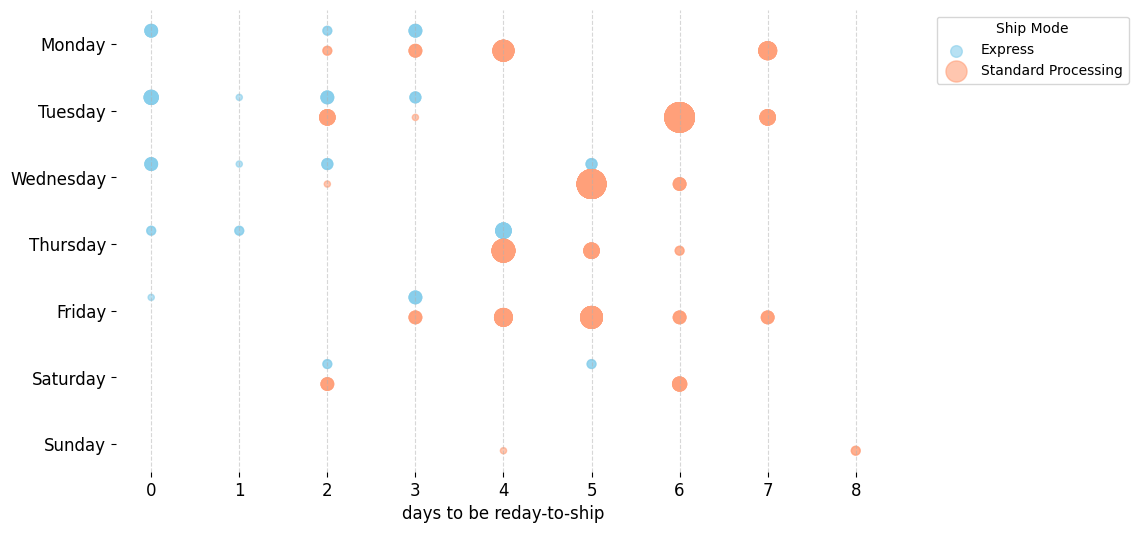

In [186]:
import matplotlib.pyplot as plt
import pandas as pd

weekdays = ['Sunday','Saturday','Friday','Thursday','Wednesday','Tuesday','Monday']

muesli_step1['order_date_day'] = pd.Categorical(
    muesli_step1['order_date_day'], categories=weekdays, ordered=True
)

plt.figure(figsize=(10,6))

def get_sizes(data):
    counts = data.groupby(['order_date_day','time_order_ship']).size().reset_index(name='count')
    data = data.merge(counts, on=['order_date_day','time_order_ship'])
    data['size'] = data['count'] * 20 
    return data

express_data = muesli_step1[muesli_step1['ship mode_y'] == 'Express']
express_data = get_sizes(express_data)
plt.scatter(
    express_data['time_order_ship'].dt.days,
    express_data['order_date_day'].cat.codes + 0.2,
    s=express_data['size'],
    color='skyblue',
    alpha=0.6,
    label='Express'
)

standard_data = muesli_step1[muesli_step1['ship mode_y'] == 'Standard Processing']
standard_data = get_sizes(standard_data)
plt.scatter(
    standard_data['time_order_ship'].dt.days,
    standard_data['order_date_day'].cat.codes - 0.1,
    s=standard_data['size'],
    color='lightsalmon',
    alpha=0.6,
    label='Standard Processing'
)

plt.xlabel('days to be reday-to-ship', fontsize=12)

plt.yticks(range(len(weekdays)), weekdays, fontsize=12)
plt.xticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.legend(title='Ship Mode', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
